In [1]:
using PyPlot, Distributions, Statistics
using Distributions:Random
plt[:style][:use]("seaborn")
Random.seed!(1234)

MersenneTwister(1234)

### 基本的モンテカルロ積分法

#### 例1

区間 $[0, 1]$ 上に関数 $f(x)$ を

$$f(x) = (cos(50x) + sin(20x))^2$$

と定義してプロットしてみる

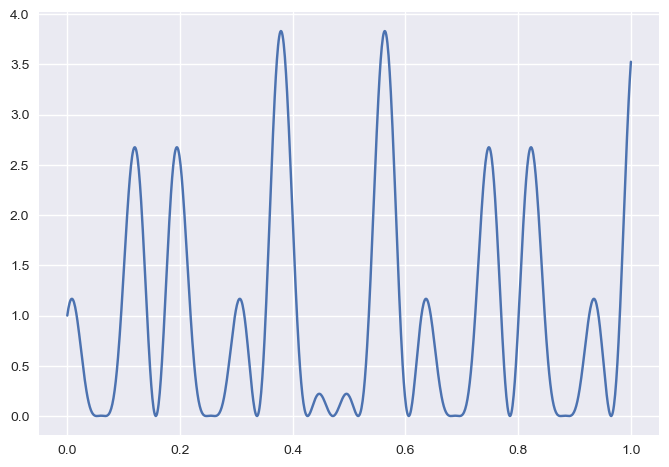

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc288369370>

In [2]:
function f(x)
    return (cos.(50 .* x) + sin.(20 .* x)) .^ 2
end

x = collect(0.0:0.001:1.0)
plot(x, f(x), label="f(x)")

基本的モンテカルロ積分法で以下の積分を近似

<br/>
$$I = \int_{0}^{1}f(x)dx$$
<br/>

具体的には, 一様乱数 $u  U(0, 1)$ を発生させ,  $f(u)$ の平均をとる.

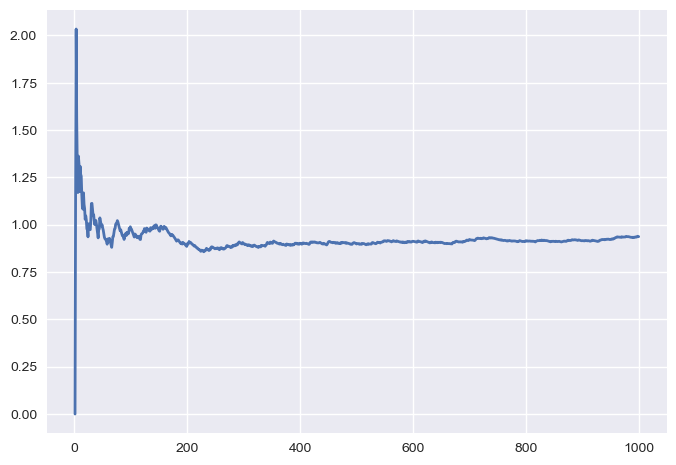

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc26cda86a0>

In [3]:
function mc_methods(num_samples::Int)
    uni_rand = rand(num_samples)
    f_x = f(uni_rand)
    means = zeros(Float32, num_samples)
    
    for i = 2:num_samples
        means[i] = sum(f_x[1:i]) / i
    end
    
    return means
end

num_samples = 1000
x = collect(1:1:1000)
means = mc_methods(num_samples)
plot(x, means, label="mean", linewidth=2)

#### 例2：
$N$ 個の観測 $x_1, ..., x_N$ がコーシー分布 $C(\theta, 1)$ に従い,  パラメータ $\theta$ の事前分布が $C(0, 1)$ であると仮定する. この時の $x$ の周辺確率密度は

<br/>
$$p(x^N) = \int_{-\infty}^{\infty}p(x^N|\theta)p(\theta)d\theta$$
<br/>

この積分を基本モンテカルロ法を用いて計算するには,　$\theta$ を $C(0, 1)$ から $M$ 個生成し, 

<br/>
$$\frac{1}{M}\sum^{M}_{m=1}\prod^{N}_{n=1}\frac{1}{\pi(1 + (x_n - \theta_m)^2)}$$
<br/>

を計算すればよい.

In [4]:
N = 100
M = 1000
cauchy = Cauchy(0, 1)
x = rand(cauchy, N) .+ 1
theta = rand(cauchy, M)
means = zeros(Float64, M)

tmp = 0
for i = 1:M
    tmp += prod(1 ./ (pi .* ((x .- theta[i]).^2 .+ 1)))
    means[i] = tmp / i
end

print(tmp / M)
# iter = collect(1:1:M)
# plot(iter, means, label="mean", linewidth=2)

5.486229832248646e-94

#### 例3：
上の問題と同様にコーシー分布の裾確率を計算してみる. 積分は以下

<br/>
$$I = \int_{2}^{\infty}\frac{1}{\pi(1 + x^2)}dx$$
<br/>

今回は信頼係数95%の(近似)信頼区間もプロットしてみる.

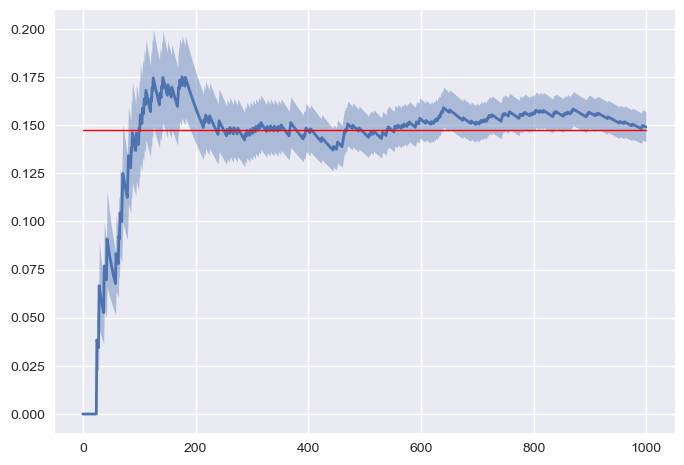

PyObject <matplotlib.collections.PolyCollection object at 0x7fc2702a5190>

In [12]:
function f(x)
    if x >= 2
        return 1
    else
        return 0
    end
end

"""
Montecarlo method
"""
function calc_I_and_CI()
    M = 1000
    cauchy_rand =rand(Cauchy(0, 1), M)
    fs = f.(cauchy_rand)
    
    # MCM
    I_mean = zeros(Float32, M)
    for i = 1:M
        I_mean[i] = mean(fs[1:i])
    end
    
    # Calculate 95% CI
    sigma = zeros(Float32, M)
    for i = 2:M
        sigma[i] = sum((fs[1:i] .- I_mean[i]) .^ 2) / (i - 1)
    end
    alpha = 0.025
    c = quantile(Normal(0, 1), 1-alpha)
    L = zeros(Float32, M) 
    U = zeros(Float32, M)
    
    for i = 1:M
        L[i] = I_mean[i] - (1 / sqrt(i)) * sigma[i] * c
        U[i] = I_mean[i] + (1 / sqrt(i)) * sigma[i] * c
    end
    
    return (I_mean, L, U)
end

iter = collect(1:1:M)
I_mean, L, U = calc_I_and_CI()

# True value
true_val = ones(M) ./ 2 .- atan(2) / pi

plot(I_mean, label="I_mean", linewidth=2)
plot(true_val, color="red", linewidth=1)
fill_between(iter, L, U, alpha=0.4)

### 自己正規化モンテカルロ積分法
